## 1. Import Libraries

In [4]:
# Data manipulation
import json
import pandas as pd
import numpy as np
from pathlib import Path

# Text processing
import re
from bs4 import BeautifulSoup
from collections import Counter

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Natural Language Processing
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Download required NLTK data
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')
    
try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')

# Settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 100)
sns.set_style('whitegrid')

print("✅ All libraries imported successfully!")

✅ All libraries imported successfully!


## 2. Load Raw Dataset

In [5]:
# Define file paths
DATA_DIR = Path("./")
JSON_FILE = DATA_DIR / "nemesis.json"
OUTPUT_DIR = DATA_DIR / "data"

# Create output directory if not exists
OUTPUT_DIR.mkdir(exist_ok=True)

print(f"📂 Data directory: {DATA_DIR.resolve()}")
print(f"📄 Input file: {JSON_FILE.name}")
print(f"💾 Output directory: {OUTPUT_DIR.resolve()}")

📂 Data directory: C:\Users\Nguyen Ngo\Downloads\NLP PApere\NLP-Trade-Message
📄 Input file: nemesis.json
💾 Output directory: C:\Users\Nguyen Ngo\Downloads\NLP PApere\NLP-Trade-Message\data


In [6]:
# Load JSON data
with open(JSON_FILE, 'r', encoding='utf-8') as f:
    data = json.load(f)

# Extract pages array
pages = data['pages']

print(f"✅ Loaded {len(pages)} marketplace listings")
print(f"\n📋 Sample listing structure:")
print(f"   Keys: {list(pages[0].keys())}")

✅ Loaded 1334 marketplace listings

📋 Sample listing structure:
   Keys: ['title', 'url', 'text', 'timestamp']


In [7]:
# Create initial DataFrame
df_raw = pd.DataFrame(pages)

print(f"📊 Raw DataFrame shape: {df_raw.shape}")
print(f"\n🔍 Columns: {df_raw.columns.tolist()}")
print(f"\n📈 Memory usage: {df_raw.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

📊 Raw DataFrame shape: (1334, 4)

🔍 Columns: ['title', 'url', 'text', 'timestamp']

📈 Memory usage: 38.22 MB


## 3. Exploratory Data Analysis (EDA)

In [8]:
# Display first few rows
print("🔎 First 3 listings:")
df_raw.head(3)

🔎 First 3 listings:


,title,url,text,timestamp
0,USA FULLZ + DL + BACKGROUND REPORT MONTANA | Nemesis Market,http://nemesis555nchzn2dogee6mlc7xxgeeshqirmh3yzn4lo5cnd4s5a4yd.onion/item/m9bgov81hz,USA FULLZ + DL + BACKGROUND REPORT MONTANA | Nemesis Market * !Nemesis Market(/assets/media/lo...,2023-01-11T13:00:52
1,1 x POWER PLANT XL autoflower seed | Nemesis Market,http://nemesis555nchzn2dogee6mlc7xxgeeshqirmh3yzn4lo5cnd4s5a4yd.onion/item/xt27064vc2,1 x POWER PLANT XL autoflower seed | Nemesis Market * !Nemesis Market(/assets/media/logos/logo...,2023-01-11T13:00:01
2,Ship Marijuana Safely - Instant Delivery | Nemesis Market,http://nemesis555nchzn2dogee6mlc7xxgeeshqirmh3yzn4lo5cnd4s5a4yd.onion/item/5azwilxmle,Ship Marijuana Safely - Instant Delivery | Nemesis Market * !Nemesis Market(/assets/media/logo...,2023-01-11T12:59:34


In [9]:
# Check for missing values
print("❓ Missing values per column:")
missing_info = pd.DataFrame({
    'Missing Count': df_raw.isnull().sum(),
    'Percentage': (df_raw.isnull().sum() / len(df_raw) * 100).round(2)
})
print(missing_info[missing_info['Missing Count'] > 0])

if missing_info['Missing Count'].sum() == 0:
    print("\n✅ No missing values detected!")

❓ Missing values per column:
Empty DataFrame
Columns: [Missing Count, Percentage]
Index: []

✅ No missing values detected!


📏 Title length statistics:
count    1334.000000
mean       61.573463
std        17.128224
min        20.000000
25%        50.000000
50%        60.000000
75%        72.000000
max       100.000000
Name: title_length, dtype: float64


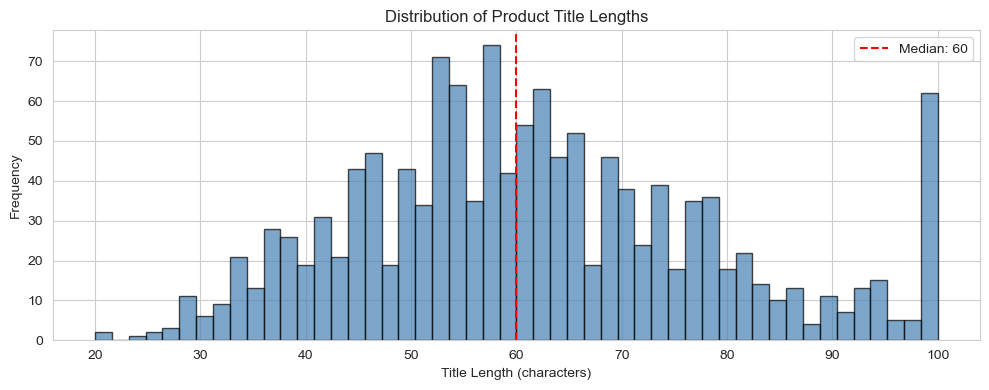

In [10]:
# Analyze title lengths
df_raw['title_length'] = df_raw['title'].str.len()

print("📏 Title length statistics:")
print(df_raw['title_length'].describe())

# Plot title length distribution
plt.figure(figsize=(10, 4))
plt.hist(df_raw['title_length'], bins=50, color='steelblue', edgecolor='black', alpha=0.7)
plt.xlabel('Title Length (characters)')
plt.ylabel('Frequency')
plt.title('Distribution of Product Title Lengths')
plt.axvline(df_raw['title_length'].median(), color='red', linestyle='--', label=f'Median: {df_raw["title_length"].median():.0f}')
plt.legend()
plt.tight_layout()
plt.show()

In [11]:
# Sample titles for inspection
print("📝 Sample product titles:")
for i, title in enumerate(df_raw['title'].sample(5, random_state=42), 1):
    print(f"{i}. {title}")

📝 Sample product titles:
1. #1 ANDROID Carding Setup! NO ROOT, NO FAIL | Nemesis Market
2. 75tabs of Mickey Mouse LSD 250ug FREE NDD - UK | Nemesis Market
3. 20G  AAA+++ BISCOTTI *L.A CALI IMPORT* - UK NDD | Nemesis Market
4. IPTV from Armenia | Nemesis Market
5. Tgirl-network.com Porn Account Warranty | Nemesis Market


## 4. Category Mapping & Labeling

**Strategy:** Extract category information from the page text and map to simplified labels.

**Target Categories:**
- `drug`: All drug-related products (Cannabis, Stimulants, Opioids, Psychedelics, etc.)
- `accessory`: Drug-related accessories and paraphernalia
- `fraud`: Fraud-related items (cards, accounts, documents)
- `hacking`: Hacking tools and services
- `other`: Everything else (guides, tutorials, etc.)

In [12]:
def extract_category_from_text(text):
    """
    Extract category from the marketplace page text.
    Categories appear in breadcrumb navigation like: 'Drugs » Cannabis » Seeds'
    """
    if pd.isna(text):
        return None, None, None
    
    # Look for category breadcrumb pattern
    # Pattern: "Drugs  » Cannabis  » Seeds" or similar
    category_pattern = r'(Drugs|Fraud|Hacking|Forgeries/Counterfeits|Other)\s*»\s*([^\n]+?)(?:\s*»\s*([^\n]+?))?\s*\n'
    
    match = re.search(category_pattern, text)
    
    if match:
        root_category = match.group(1).strip()
        subcategory = match.group(2).strip() if match.group(2) else None
        sub_subcategory = match.group(3).strip() if match.group(3) else None
        return root_category, subcategory, sub_subcategory
    
    return None, None, None

# Apply category extraction
print("🏷️  Extracting categories from text...")
df_raw[['root_category', 'subcategory', 'sub_subcategory']] = df_raw['text'].apply(
    lambda x: pd.Series(extract_category_from_text(x))
)

print("\n✅ Category extraction complete!")
print(f"\n📊 Category distribution:")
print(df_raw['root_category'].value_counts(dropna=False))

🏷️  Extracting categories from text...

✅ Category extraction complete!

📊 Category distribution:
root_category
Drugs                     607
Fraud                     415
Other                     230
Hacking                    45
Forgeries/Counterfeits     37
Name: count, dtype: int64


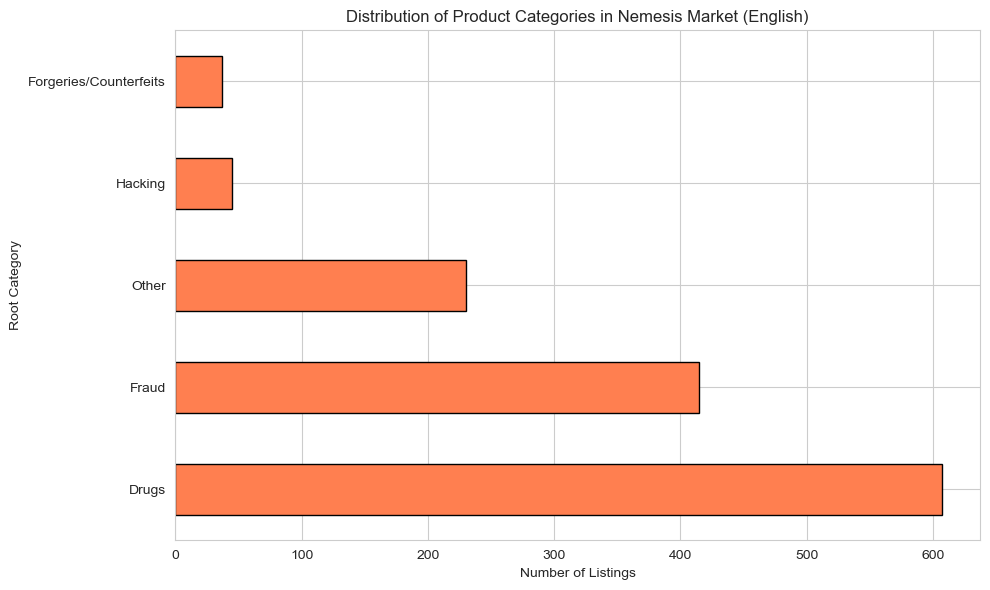

In [13]:
# Visualize category distribution
category_counts = df_raw['root_category'].value_counts(dropna=False)

plt.figure(figsize=(10, 6))
category_counts.plot(kind='barh', color='coral', edgecolor='black')
plt.xlabel('Number of Listings')
plt.ylabel('Root Category')
plt.title('Distribution of Product Categories in Nemesis Market (English)')
plt.tight_layout()
plt.show()

In [14]:
# Map to simplified labels
def map_to_label(root_category, subcategory):
    """
    Map raw categories to simplified classification labels.
    
    Labels:
    - drug: All drug products
    - accessory: Paraphernalia and drug accessories
    - fraud: Fraud-related items
    - hacking: Hacking tools and services
    - other: Guides, tutorials, misc items
    """
    if pd.isna(root_category):
        return 'unknown'
    
    root_lower = root_category.lower()
    
    if 'drug' in root_lower:
        # Check if it's paraphernalia/accessories
        if subcategory and 'paraphernalia' in subcategory.lower():
            return 'accessory'
        return 'drug'
    
    elif 'fraud' in root_lower or 'forgeries' in root_lower or 'counterfeits' in root_lower:
        return 'fraud'
    
    elif 'hacking' in root_lower:
        return 'hacking'
    
    elif 'other' in root_lower:
        # Check subcategory for more specific classification
        if subcategory:
            sub_lower = subcategory.lower()
            if 'guide' in sub_lower or 'tutorial' in sub_lower:
                return 'guide'
        return 'other'
    
    return 'other'

# Apply label mapping
print("🏷️  Mapping categories to simplified labels...")
df_raw['label'] = df_raw.apply(
    lambda row: map_to_label(row['root_category'], row['subcategory']), 
    axis=1
)

print("\n✅ Label mapping complete!")
print(f"\n📊 Label distribution:")
label_dist = df_raw['label'].value_counts()
print(label_dist)
print(f"\nPercentages:")
print((label_dist / len(df_raw) * 100).round(2))

🏷️  Mapping categories to simplified labels...

✅ Label mapping complete!

📊 Label distribution:
label
drug       607
fraud      452
guide      134
other       96
hacking     45
Name: count, dtype: int64

Percentages:
label
drug       45.50
fraud      33.88
guide      10.04
other       7.20
hacking     3.37
Name: count, dtype: float64


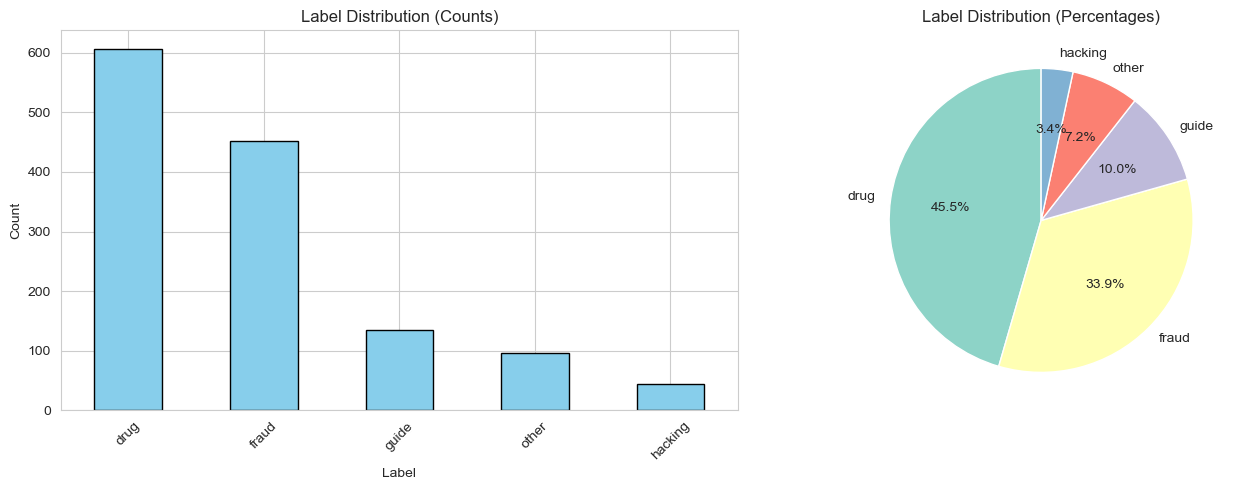

In [15]:
# Visualize label distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Bar chart
label_dist.plot(kind='bar', ax=ax1, color='skyblue', edgecolor='black')
ax1.set_xlabel('Label')
ax1.set_ylabel('Count')
ax1.set_title('Label Distribution (Counts)')
ax1.tick_params(axis='x', rotation=45)

# Pie chart
colors = plt.cm.Set3(range(len(label_dist)))
ax2.pie(label_dist, labels=label_dist.index, autopct='%1.1f%%', colors=colors, startangle=90)
ax2.set_title('Label Distribution (Percentages)')

plt.tight_layout()
plt.show()

In [16]:
# Sample examples from each label
print("📋 Sample titles from each category:\n")
for label in df_raw['label'].unique():
    print(f"\n{'='*60}")
    print(f"Label: {label.upper()}")
    print(f"{'='*60}")
    samples = df_raw[df_raw['label'] == label]['title'].sample(min(3, len(df_raw[df_raw['label'] == label])), random_state=42)
    for i, title in enumerate(samples, 1):
        print(f"{i}. {title}")

📋 Sample titles from each category:


Label: FRAUD
1. Frontside Drivers License | Nemesis Market
2. Kansas Driver License Digital Scan | Nemesis Market
3. bankdrops link to kraken account instock | Nemesis Market

Label: DRUG
1. 125g Of Mimosa Cannabis Dust - AUSTRALIAN IMPORT FREE NDD | Nemesis Market
2. BEST KETAMINE/KET/KETAMIN PURE INDIAN S-ISOMER LONG SHARDS 28G ***FREE UK DELIVERY*** | Nemesis Mark
3. ** AMNESIA ROSIN / WAX ** - Solventless - TOP CONCENTRATE - AAA+++ | Nemesis Market

Label: GUIDE
1. How not to get blocked your fake FB account | Nemesis Market
2. How to trace a Email sender 2021 method | Nemesis Market
3. 2023 STOP GETTING DECLINED CARDING GUIDE ! *NEW* | Nemesis Market

Label: HACKING
1. Wifi Password Auto Hack Soft With Tutorial- Works! + 1 USA CC EXTRA FREE + Mega Carding Updated Pack
2. NjRAT Final Edition | Nemesis Market
3. Freya Bitcoin Clipper Builder | Nemesis Market

Label: OTHER
1. ♚ HOW TO HACK CREDIT CARD DATA FULL TUTORIAL ♚ | Nemesis Market
2. ♚ Ca

## 5. Text Extraction & Combination

Extract product description from the HTML text and combine with title to create unified text field.

In [17]:
def extract_description(text):
    """
    Extract product description from the marketplace page text.
    Description appears after 'Description' tab/section.
    """
    if pd.isna(text):
        return ""
    
    # Remove HTML-like markup
    text = re.sub(r'!\([^)]+\)', '', text)  # Remove image references
    
    # Try to extract description section
    # Pattern 1: After "* Description" until "Refund policy" or "## You may be interested"
    desc_pattern = r'\* Description\s*\* Reviews\s*(.+?)(?:Refund policy|## You may be interested|nemesis555)'
    match = re.search(desc_pattern, text, re.DOTALL)
    
    if match:
        description = match.group(1).strip()
        # Clean up extra whitespace and newlines
        description = re.sub(r'\s+', ' ', description)
        return description[:1000]  # Limit length to avoid extremely long descriptions
    
    return ""

# Extract descriptions
print("📝 Extracting product descriptions...")
df_raw['description'] = df_raw['text'].apply(extract_description)

# Check extraction success rate
desc_extracted = (df_raw['description'].str.len() > 0).sum()
print(f"\n✅ Descriptions extracted: {desc_extracted}/{len(df_raw)} ({desc_extracted/len(df_raw)*100:.1f}%)")
print(f"\n📏 Description length statistics:")
print(df_raw['description'].str.len().describe())

📝 Extracting product descriptions...

✅ Descriptions extracted: 1334/1334 (100.0%)

📏 Description length statistics:
count    1334.000000
mean      589.556222
std       350.499837
min        17.000000
25%       246.250000
50%       605.000000
75%      1000.000000
max      1000.000000
Name: description, dtype: float64


In [18]:
# Sample descriptions
print("📄 Sample descriptions:\n")
for i, (title, desc) in enumerate(df_raw[df_raw['description'].str.len() > 50][['title', 'description']].sample(3, random_state=42).values, 1):
    print(f"{i}. Title: {title}")
    print(f"   Description: {desc[:200]}...\n")

📄 Sample descriptions:

1. Title: XTC pills - Silver New York 200mg MDMA | Nemesis Market
   Description: PLEASE READ OUR PROFILE INFORMATION, SHIPPING POLICY AND REFUND POLICY BEFORE PLACING AN ORDER! XTC pills containing 200mg of high quality MDMA each. The pills are hard professionally pressed in the N...

2. Title: Config Openbullet loli Uptobox - Full Capture | Nemesis Market
   Description: This is a config in .loli (who work with openbullet) that i created It is a config who work and tested by myself She works with free proxies, but you will get higher CPM (Check per minute) with HQ pro...

3. Title: Authentic Durban Poison | Nemesis Market
   Description: My weed is sourced directly in Durban, South Africa where I live. You don't get more authentic than that. This is as rare as hen's teeth following recent floods - I'm very lucky to get this. Durban Po...



In [19]:
# Combine title and description into unified text field
def combine_text(row):
    """
    Combine title and description with proper formatting.
    """
    title = str(row['title']) if pd.notna(row['title']) else ""
    description = str(row['description']) if pd.notna(row['description']) else ""
    
    # Combine with separator
    if description:
        return f"{title}. {description}"
    return title

print("🔗 Combining title and description...")
df_raw['combined_text'] = df_raw.apply(combine_text, axis=1)

print(f"\n✅ Text combination complete!")
print(f"\n📏 Combined text length statistics:")
print(df_raw['combined_text'].str.len().describe())

🔗 Combining title and description...

✅ Text combination complete!

📏 Combined text length statistics:
count    1334.000000
mean      653.129685
std       352.942874
min        53.000000
25%       309.000000
50%       668.500000
75%      1047.000000
max      1102.000000
Name: combined_text, dtype: float64


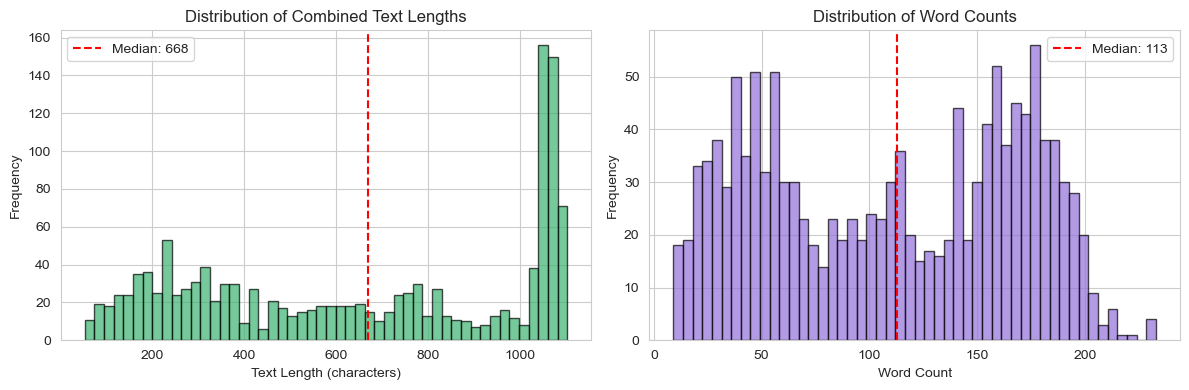

In [20]:
# Visualize text length distribution
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.hist(df_raw['combined_text'].str.len(), bins=50, color='mediumseagreen', edgecolor='black', alpha=0.7)
plt.xlabel('Text Length (characters)')
plt.ylabel('Frequency')
plt.title('Distribution of Combined Text Lengths')
plt.axvline(df_raw['combined_text'].str.len().median(), color='red', linestyle='--', 
            label=f'Median: {df_raw["combined_text"].str.len().median():.0f}')
plt.legend()

plt.subplot(1, 2, 2)
plt.hist(df_raw['combined_text'].str.split().str.len(), bins=50, color='mediumpurple', edgecolor='black', alpha=0.7)
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.title('Distribution of Word Counts')
plt.axvline(df_raw['combined_text'].str.split().str.len().median(), color='red', linestyle='--',
            label=f'Median: {df_raw["combined_text"].str.split().str.len().median():.0f}')
plt.legend()

plt.tight_layout()
plt.show()

## 6. Text Cleaning & Preprocessing

Clean and normalize text data for NLP analysis:
1. Convert to lowercase
2. Remove URLs and special characters
3. Remove extra whitespace
4. Remove stopwords (optional, can be done later)
5. Handle currency symbols and numbers

In [21]:
def clean_text(text):
    """
    Comprehensive text cleaning function.
    
    Steps:
    1. Convert to lowercase
    2. Remove URLs
    3. Remove email addresses
    4. Remove special characters (keep basic punctuation)
    5. Remove extra whitespace
    6. Remove very short words (1-2 chars) that are not meaningful
    """
    if pd.isna(text) or text == "":
        return ""
    
    # Convert to lowercase
    text = text.lower()
    
    # Remove URLs (including .onion addresses)
    text = re.sub(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', text)
    text = re.sub(r'\S+\.onion\S*', '', text)
    
    # Remove email addresses
    text = re.sub(r'\S+@\S+', '', text)
    
    # Remove price patterns (e.g., "$10", "10 USD", "10.99 EUR")
    text = re.sub(r'\$?\d+\.?\d*\s*(usd|eur|gbp|btc|xmr)', '', text)
    text = re.sub(r'\d+\.?\d*\s*usd|eur|gbp|btc', '', text)
    
    # Remove excessive numbers (keep numbers that might be meaningful like dosages)
    # But remove long number sequences
    text = re.sub(r'\b\d{5,}\b', '', text)
    
    # Remove special characters but keep basic punctuation and spaces
    text = re.sub(r'[^a-z0-9\s.!?,-]', ' ', text)
    
    # Remove bullet points and list markers
    text = re.sub(r'[•\*\+\-]+', ' ', text)
    
    # Collapse multiple spaces into one
    text = re.sub(r'\s+', ' ', text)
    
    # Remove leading/trailing whitespace
    text = text.strip()
    
    return text

# Apply text cleaning
print("🧹 Cleaning text data...")
df_raw['clean_text'] = df_raw['combined_text'].apply(clean_text)

print("\n✅ Text cleaning complete!")
print(f"\n📏 Clean text length statistics:")
print(df_raw['clean_text'].str.len().describe())

🧹 Cleaning text data...

✅ Text cleaning complete!

📏 Clean text length statistics:
count    1334.000000
mean      627.830585
std       344.843794
min        47.000000
25%       296.000000
50%       642.500000
75%      1012.000000
max      1099.000000
Name: clean_text, dtype: float64


In [22]:
# Compare before and after cleaning
print("🔍 Text cleaning comparison:\n")
samples = df_raw.sample(3, random_state=42)

for i, (original, cleaned) in enumerate(zip(samples['combined_text'], samples['clean_text']), 1):
    print(f"{i}. BEFORE: {original[:150]}...")
    print(f"   AFTER:  {cleaned[:150]}...\n")

🔍 Text cleaning comparison:

1. BEFORE: #1 ANDROID Carding Setup! NO ROOT, NO FAIL | Nemesis Market. Introducing cheap guides and tutorials in shop! ~ Always Fast/Automatic delivery ~ All gu...
   AFTER:  1 android carding setup! no root, no fail nemesis market. introducing cheap guides and tutorials in shop! always fast automatic delivery all guides ar...

2. BEFORE: 75tabs of Mickey Mouse LSD 250ug FREE NDD - UK | Nemesis Market. MICKEY MOUSE LSD 250ug LSD tabs High Quality, Lab Tested Free Shipping ORDER NOW, REC...
   AFTER:  75tabs of mickey mouse lsd 250ug free ndd uk nemesis market. mickey mouse lsd 250ug lsd tabs high quality, lab tested free shipping order now, recieve...

3. BEFORE: 20G  AAA+++ BISCOTTI *L.A CALI IMPORT* - UK NDD | Nemesis Market. Biscotti is a potent indica-dominant hybrid marijuana strain made by crossing Gelato...
   AFTER:  20g aaa biscotti l.a cali import uk ndd nemesis market. biscotti is a potent indica dominant hybrid marijuana strain made by crossing

In [23]:
# Remove empty or very short cleaned texts
min_length = 10  # Minimum 10 characters

before_filter = len(df_raw)
df_raw = df_raw[df_raw['clean_text'].str.len() >= min_length].copy()
after_filter = len(df_raw)

print(f"🚫 Removed {before_filter - after_filter} entries with text length < {min_length} characters")
print(f"✅ Remaining entries: {after_filter}")

🚫 Removed 0 entries with text length < 10 characters
✅ Remaining entries: 1334


📊 Word count statistics:
count    1334.000000
mean      106.202399
std        59.064966
min         8.000000
25%        52.000000
50%       107.500000
75%       163.750000
max       222.000000
Name: word_count, dtype: float64


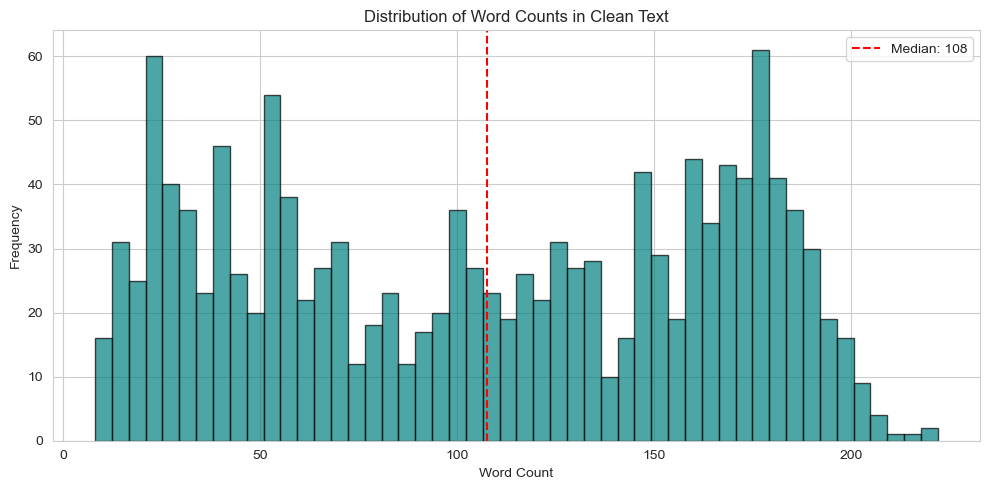

In [24]:
# Word count statistics
df_raw['word_count'] = df_raw['clean_text'].str.split().str.len()

print("📊 Word count statistics:")
print(df_raw['word_count'].describe())

plt.figure(figsize=(10, 5))
plt.hist(df_raw['word_count'], bins=50, color='teal', edgecolor='black', alpha=0.7)
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.title('Distribution of Word Counts in Clean Text')
plt.axvline(df_raw['word_count'].median(), color='red', linestyle='--', 
            label=f'Median: {df_raw["word_count"].median():.0f}')
plt.legend()
plt.tight_layout()
plt.show()

## 7. Save Clean Dataset

In [25]:
# Select columns for final dataset
columns_to_save = [
    'title',
    'url',
    'root_category',
    'subcategory',
    'label',
    'combined_text',
    'clean_text',
    'word_count',
    'timestamp'
]

df_clean = df_raw[columns_to_save].copy()

print(f"📋 Final dataset shape: {df_clean.shape}")
print(f"\n🔍 Columns in clean dataset:")
for col in df_clean.columns:
    print(f"   - {col}")

📋 Final dataset shape: (1334, 9)

🔍 Columns in clean dataset:
   - title
   - url
   - root_category
   - subcategory
   - label
   - combined_text
   - clean_text
   - word_count
   - timestamp


In [26]:
# Save to CSV
output_file = OUTPUT_DIR / "english_clean.csv"

df_clean.to_csv(output_file, index=False, encoding='utf-8')

print(f"💾 Dataset saved to: {output_file.resolve()}")
print(f"📊 File size: {output_file.stat().st_size / 1024**2:.2f} MB")
print(f"\n✅ Total records saved: {len(df_clean)}")

💾 Dataset saved to: C:\Users\Nguyen Ngo\Downloads\NLP PApere\NLP-Trade-Message\data\english_clean.csv
📊 File size: 1.90 MB

✅ Total records saved: 1334


In [27]:
# Preview saved data
print("🔍 Preview of saved dataset:\n")
df_clean.head(10)

🔍 Preview of saved dataset:



,title,url,root_category,subcategory,label,combined_text,clean_text,word_count,timestamp
0,USA FULLZ + DL + BACKGROUND REPORT MONTANA | Nemesis Market,http://nemesis555nchzn2dogee6mlc7xxgeeshqirmh3yzn4lo5cnd4s5a4yd.onion/item/m9bgov81hz,Fraud,SSN/DOB/DL/PII,fraud,USA FULLZ + DL + BACKGROUND REPORT MONTANA | Nemesis Market. USA FULLZ + DL + BACKGROUND REPORT ...,usa fullz dl background report montana nemesis market. usa fullz dl background report montana na...,23,2023-01-11T13:00:52
1,1 x POWER PLANT XL autoflower seed | Nemesis Market,http://nemesis555nchzn2dogee6mlc7xxgeeshqirmh3yzn4lo5cnd4s5a4yd.onion/item/xt27064vc2,Drugs,Cannabis,drug,1 x POWER PLANT XL autoflower seed | Nemesis Market. POWER PLANT XL AUTOFLOWERING: FIRST-CLASS H...,1 x power plant xl autoflower seed nemesis market. power plant xl autoflowering first class haze...,189,2023-01-11T13:00:01
2,Ship Marijuana Safely - Instant Delivery | Nemesis Market,http://nemesis555nchzn2dogee6mlc7xxgeeshqirmh3yzn4lo5cnd4s5a4yd.onion/item/5azwilxmle,Other,Guides and Tutorials,guide,Ship Marijuana Safely - Instant Delivery | Nemesis Market. Marijuana still remains illegal at th...,ship marijuana safely instant delivery nemesis market. marijuana still remains illegal at the fe...,142,2023-01-11T12:59:34
3,1x Feminized AUTOFLOWER AK-47 Cannabis Seeds | Nemesis Market,http://nemesis555nchzn2dogee6mlc7xxgeeshqirmh3yzn4lo5cnd4s5a4yd.onion/item/hp3yh0sdtq,Drugs,Cannabis,drug,1x Feminized AUTOFLOWER AK-47 Cannabis Seeds | Nemesis Market. Welcome to the safest shop on the...,1x feminized autoflower ak 47 cannabis seeds nemesis market. welcome to the safest shop on the d...,178,2023-01-11T12:59:08
4,1 x KALASHNIKOV autoflower seed | Nemesis Market,http://nemesis555nchzn2dogee6mlc7xxgeeshqirmh3yzn4lo5cnd4s5a4yd.onion/item/7h59xlvsfu,Drugs,Cannabis,drug,1 x KALASHNIKOV autoflower seed | Nemesis Market. KALASHNIKOV AUTOFLOWERING: AN AUTO SUPERSTAR K...,1 x kalashnikov autoflower seed nemesis market. kalashnikov autoflowering an auto superstar kala...,170,2023-01-11T12:58:53
5,1x Feminized GORILLA GLUE Cannabis Seeds | Nemesis Market,http://nemesis555nchzn2dogee6mlc7xxgeeshqirmh3yzn4lo5cnd4s5a4yd.onion/item/jmtf1occzx,Drugs,Cannabis,drug,1x Feminized GORILLA GLUE Cannabis Seeds | Nemesis Market. Welcome to the safest shop on the dar...,1x feminized gorilla glue cannabis seeds nemesis market. welcome to the safest shop on the darkw...,175,2023-01-11T12:58:41
6,File Management Software for Hackers | Nemesis Market,http://nemesis555nchzn2dogee6mlc7xxgeeshqirmh3yzn4lo5cnd4s5a4yd.onion/item/s9i4ruv8cv,Hacking,Other,hacking,File Management Software for Hackers | Nemesis Market. This product will allow you to make your ...,file management software for hackers nemesis market. this product will allow you to make your tr...,145,2023-01-11T03:36:49
7,1x Feminized CHEESE Cannabis Seeds from the Netherlands | Nemesis Market,http://nemesis555nchzn2dogee6mlc7xxgeeshqirmh3yzn4lo5cnd4s5a4yd.onion/item/ery9rpygvg,Drugs,Cannabis,drug,1x Feminized CHEESE Cannabis Seeds from the Netherlands | Nemesis Market. Welcome to the safest ...,1x feminized cheese cannabis seeds from the netherlands nemesis market. welcome to the safest sh...,176,2023-01-11T03:35:04
8,CEH Prep Guide 45$ | Nemesis Market,http://nemesis555nchzn2dogee6mlc7xxgeeshqirmh3yzn4lo5cnd4s5a4yd.onion/item/tuxx4fb4hh,Hacking,Other,hacking,CEH Prep Guide 45$ | Nemesis Market. all our tutorials and methods are working and tested 100% d...,ceh prep guide 45 nemesis market. all our tutorials and methods are working and tested 100 don t...,39,2023-01-11T03:33:45
9,CodeAcademy Premium Account | LIFETIME | | Nemesis Market,http://nemesis555nchzn2dogee6mlc7xxgeeshqirmh3yzn4lo5cnd4s5a4yd.onion/item/hv6ljqvsu9,Fraud,Logins/Hacked Accounts,fraud,CodeAcademy Premium Account | LIFETIME | | Nemesis Market. BEST ACCOUNTS SELLER SINCE 2018 Codec...,codeacademy premium account lifetime nemesis market. best accounts seller since 2018 codecademy ...,107,2023-01-11T03:

## 8. Validation & Summary Statistics

In [28]:
# Verify saved file can be loaded
print("🔄 Verifying saved file...")
df_verify = pd.read_csv(output_file)

assert len(df_verify) == len(df_clean), "Row count mismatch!"
assert list(df_verify.columns) == columns_to_save, "Column mismatch!"

print("✅ File verification successful!")
print(f"\n📊 Loaded {len(df_verify)} records with {len(df_verify.columns)} columns")

🔄 Verifying saved file...
✅ File verification successful!

📊 Loaded 1334 records with 9 columns


In [29]:
# Final summary statistics
print("="*70)
print("📊 FINAL DATASET SUMMARY")
print("="*70)

print(f"\n📁 Output file: {output_file.name}")
print(f"📏 Total records: {len(df_clean):,}")
print(f"💾 File size: {output_file.stat().st_size / 1024**2:.2f} MB")

print(f"\n🏷️  LABEL DISTRIBUTION:")
label_summary = df_clean['label'].value_counts()
for label, count in label_summary.items():
    percentage = count / len(df_clean) * 100
    print(f"   {label:15s}: {count:5d} ({percentage:5.2f}%)")

print(f"\n📝 TEXT STATISTICS:")
print(f"   Average word count: {df_clean['word_count'].mean():.1f}")
print(f"   Median word count:  {df_clean['word_count'].median():.0f}")
print(f"   Min word count:     {df_clean['word_count'].min()}")
print(f"   Max word count:     {df_clean['word_count'].max()}")

print(f"\n✅ Data preprocessing complete!")
print("="*70)

📊 FINAL DATASET SUMMARY

📁 Output file: english_clean.csv
📏 Total records: 1,334
💾 File size: 1.90 MB

🏷️  LABEL DISTRIBUTION:
   drug           :   607 (45.50%)
   fraud          :   452 (33.88%)
   guide          :   134 (10.04%)
   other          :    96 ( 7.20%)
   hacking        :    45 ( 3.37%)

📝 TEXT STATISTICS:
   Average word count: 106.2
   Median word count:  108
   Min word count:     8
   Max word count:     222

✅ Data preprocessing complete!


C:\Users\Nguyen Ngo\AppData\Local\Temp\ipykernel_13544\1637526055.py:53: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


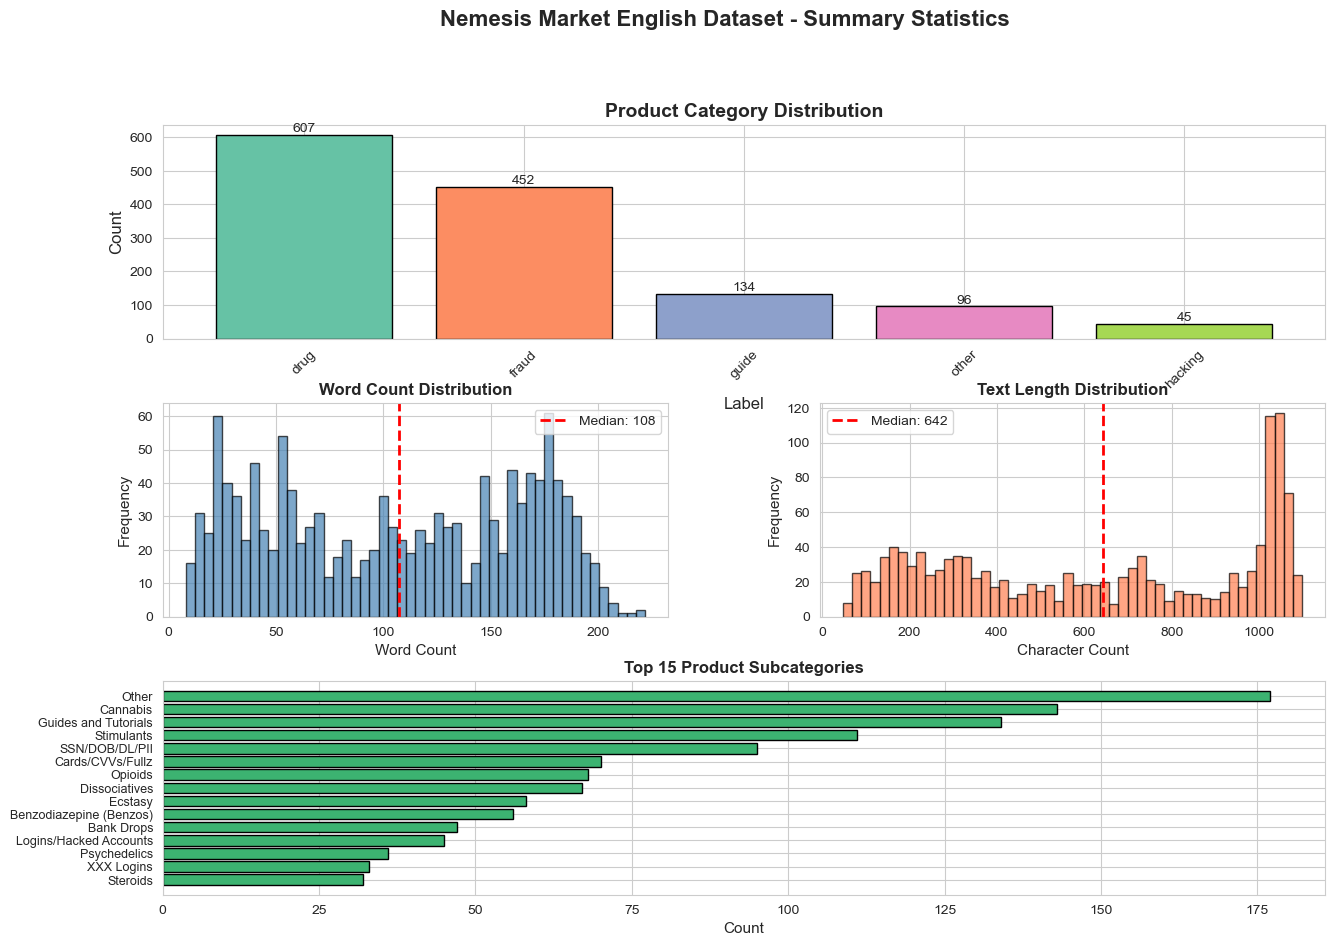

In [30]:
# Create comprehensive visualization summary
fig = plt.figure(figsize=(15, 10))
gs = fig.add_gridspec(3, 2, hspace=0.3, wspace=0.3)

# 1. Label distribution
ax1 = fig.add_subplot(gs[0, :])
label_counts = df_clean['label'].value_counts()
colors_bar = plt.cm.Set2(range(len(label_counts)))
bars = ax1.bar(label_counts.index, label_counts.values, color=colors_bar, edgecolor='black')
ax1.set_xlabel('Label', fontsize=12)
ax1.set_ylabel('Count', fontsize=12)
ax1.set_title('Product Category Distribution', fontsize=14, fontweight='bold')
ax1.tick_params(axis='x', rotation=45)
# Add count labels on bars
for bar in bars:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height)}',
             ha='center', va='bottom', fontsize=10)

# 2. Word count distribution
ax2 = fig.add_subplot(gs[1, 0])
ax2.hist(df_clean['word_count'], bins=50, color='steelblue', edgecolor='black', alpha=0.7)
ax2.set_xlabel('Word Count', fontsize=11)
ax2.set_ylabel('Frequency', fontsize=11)
ax2.set_title('Word Count Distribution', fontsize=12, fontweight='bold')
ax2.axvline(df_clean['word_count'].median(), color='red', linestyle='--', linewidth=2,
            label=f'Median: {df_clean["word_count"].median():.0f}')
ax2.legend()

# 3. Text length distribution
ax3 = fig.add_subplot(gs[1, 1])
ax3.hist(df_clean['clean_text'].str.len(), bins=50, color='coral', edgecolor='black', alpha=0.7)
ax3.set_xlabel('Character Count', fontsize=11)
ax3.set_ylabel('Frequency', fontsize=11)
ax3.set_title('Text Length Distribution', fontsize=12, fontweight='bold')
ax3.axvline(df_clean['clean_text'].str.len().median(), color='red', linestyle='--', linewidth=2,
            label=f'Median: {df_clean["clean_text"].str.len().median():.0f}')
ax3.legend()

# 4. Top subcategories
ax4 = fig.add_subplot(gs[2, :])
top_subcats = df_clean['subcategory'].value_counts().head(15)
ax4.barh(range(len(top_subcats)), top_subcats.values, color='mediumseagreen', edgecolor='black')
ax4.set_yticks(range(len(top_subcats)))
ax4.set_yticklabels(top_subcats.index, fontsize=9)
ax4.set_xlabel('Count', fontsize=11)
ax4.set_title('Top 15 Product Subcategories', fontsize=12, fontweight='bold')
ax4.invert_yaxis()

plt.suptitle('Nemesis Market English Dataset - Summary Statistics', 
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

In [31]:
# Export summary statistics to text file
summary_file = OUTPUT_DIR / "preprocessing_summary.txt"

with open(summary_file, 'w', encoding='utf-8') as f:
    f.write("="*70 + "\n")
    f.write("NEMESIS MARKET ENGLISH DATASET - PREPROCESSING SUMMARY\n")
    f.write("="*70 + "\n\n")
    
    f.write(f"Generated: {pd.Timestamp.now()}\n")
    f.write(f"Output file: {output_file.name}\n")
    f.write(f"Total records: {len(df_clean):,}\n")
    f.write(f"File size: {output_file.stat().st_size / 1024**2:.2f} MB\n\n")
    
    f.write("LABEL DISTRIBUTION:\n")
    f.write("-" * 40 + "\n")
    for label, count in df_clean['label'].value_counts().items():
        percentage = count / len(df_clean) * 100
        f.write(f"  {label:15s}: {count:5d} ({percentage:5.2f}%)\n")
    
    f.write("\nTEXT STATISTICS:\n")
    f.write("-" * 40 + "\n")
    f.write(f"  Word count (mean):   {df_clean['word_count'].mean():.2f}\n")
    f.write(f"  Word count (median): {df_clean['word_count'].median():.0f}\n")
    f.write(f"  Word count (min):    {df_clean['word_count'].min()}\n")
    f.write(f"  Word count (max):    {df_clean['word_count'].max()}\n")
    f.write(f"  Word count (std):    {df_clean['word_count'].std():.2f}\n\n")
    
    f.write("TOP 10 SUBCATEGORIES:\n")
    f.write("-" * 40 + "\n")
    for i, (subcat, count) in enumerate(df_clean['subcategory'].value_counts().head(10).items(), 1):
        f.write(f"  {i:2d}. {subcat:30s}: {count:4d}\n")
    
    f.write("\n" + "="*70 + "\n")

print(f"📄 Summary statistics saved to: {summary_file.name}")

📄 Summary statistics saved to: preprocessing_summary.txt


## 🎉 Preprocessing Complete!

### What we accomplished:

✅ Loaded 1,334 marketplace listings from `nemesis.json`

✅ Extracted and mapped product categories to simplified labels

✅ Combined title + description into unified text field

✅ Cleaned and normalized text data

✅ Saved clean dataset to `data/english_clean.csv`

✅ Generated comprehensive summary statistics

### Next Steps:

1. **Feature Engineering**: TF-IDF, word embeddings
2. **Baseline Models**: Logistic Regression, SVM, Naive Bayes
3. **Advanced Models**: BERT, RoBERTa for classification
4. **Evaluation**: Accuracy, F1-score, confusion matrix
5. **Visualization**: Results analysis and interpretation